In [1]:
%matplotlib inline
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from math import log
from sklearn.base import BaseEstimator
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

/nix/store/cpi43kc607yl4jx59i5017a6xi3lb62m-python3.5-ipython-5.1.0/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
def add_map(mp, key, val):
    if key not in mp:
        mp[key] = val
    else:
        mp[key] += val

def make_data_entry(filename):
    res = {}
    res['is_spam'] = "spmsg" in filename
    with open(filename, 'r') as f:
        l = next(f)
        for n in l.split()[1:]:
            res[int(n)] = 1
        for l in f:
            for n in l.split():
                res[int(n)] = 1
    return res    

def make_dataset():
    files = glob.glob('pu1/part*/*.txt')
    entries = list(map(make_data_entry, files))
    return pd.DataFrame.from_dict(entries)

In [5]:
data = make_dataset().fillna(0)

In [6]:
data.head()

,68,70,84,274,284,526,583,779,792,1359,...,14962,18830,3370,24368,8559,14484,6045,9658,9188,6853
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
class NaiveBayes(BaseEstimator):
    
    def __init__(self, smooth_coef=1e-20, lambdas=None):
        self.smooth_coef = smooth_coef
        self.lambdas = lambdas
        
    def fit(self, X, y):
        total_counts = np.sum(X, axis=0)
        total_words = np.sum(total_counts)
        classes = np.unique(y)
        
        if self.lambdas is None:
            self.lambdas = np.ones(classes.shape[0])
            
        self.classes = classes
        self.word_probas = np.zeros((classes.shape[0], total_counts.shape[0]))
        self.class_probas = np.zeros(classes.shape[0])
        for cl in classes:
            cl_count = y[y == cl].shape[0]

            # smooth_coef затем, чтобы не вышло нулевых вероятностей
            self.word_probas[cl] = (np.sum(X[y == cl], axis=0) + self.smooth_coef) / (cl_count + self.smooth_coef * y.shape[0])
            self.class_probas[cl] = float(cl_count) / y.shape[0]
    
    def class_log_proba(self, x, cl):
        return self.lambdas[cl] + np.log(self.class_probas[cl]) + np.sum(np.log(self.word_probas[cl][x > 0]))
    
    def predict_log_proba(self, X):
        probas = np.zeros((X.shape[0], self.classes.shape[0]))
        for i in np.arange(0, X.shape[0]):
            for cl in self.classes:
                probas[i][cl] = self.class_log_proba(X[i], cl)
        return probas
        
    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

In [8]:
X = data.drop('is_spam', axis=1).values
y = data['is_spam'].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=43)

In [9]:
nb = NaiveBayes()
nb.fit(X_train, y_train)

In [10]:
y_pred = nb.predict(X_test)

In [11]:
accuracy_score(y_test, y_pred)

0.97247706422018354

In [12]:
f1_score(y_test, y_pred)

0.96808510638297862

In [13]:
cv_scores = cross_val_score(NaiveBayes(), X, y, cv=10)
cv_scores.mean()

0.97889908256880742

In [14]:
confusion_matrix(y_test, y_pred)

array([[121,   1],
       [  5,  91]])

In [15]:
def class_accuracy(y_test, y_pred, cl):
    y_cl = y_test[y_test == cl]
    y_pr = y_pred[y_test == cl]
    return float(np.sum(y_cl == y_pr)) / y_cl.shape[0]

In [16]:
class_accuracy(y_test, y_pred, 0)

0.9918032786885246

In [17]:
class_accuracy(y_test, y_pred, 1)

0.9479166666666666

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.77 µs


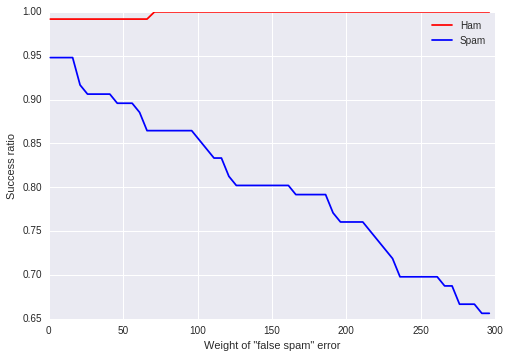

In [18]:
%time
ls = np.arange(1, 300, 5)
sc0 = []
sc1 = []

for l in ls:
    nbc = NaiveBayes(lambdas=[l, 1])
    nbc.fit(X_train, y_train)
    y_pred = nbc.predict(X_test)
    
    sc0.append(class_accuracy(y_test, y_pred, 0))
    sc1.append(class_accuracy(y_test, y_pred, 1))

plt.plot(ls, sc0, 'r-', ls, sc1, 'b-')
plt.xlabel('Weight of "false spam" error')
plt.ylabel('Success ratio')
plt.legend(['Ham', 'Spam'])
plt.show()

In [20]:
nbc = NaiveBayes(lambdas=[220, 1])
nbc.fit(X_train, y_train)
y_pred = nbc.predict(X_test)
print('Ham recall: {}'.format(class_accuracy(y_test, y_pred, 0)))
print('Spam recall: {}'.format(class_accuracy(y_test, y_pred, 1)))

Ham recall: 1.0
Spam recall: 0.7395833333333334
